# HW 7 

In this homework, we will reproduce lecture materials presented in lecture 7.
We will use Likelihood ratio method for Discovery Test, and Upper limit calculation.

Part 0, generate a pseudo-data as "Observed" events and define test statistics.
Part 1, Evaluate the Expected discovery sensitivity using Frequentist approach.
Part 2, Perform statistical tests on the "Observed" events in two approaches: Bayesian vs Frequentist.


Note that. There are only 3 Tasks (Cell 3, Cell 11 and the last Cell) in this assignment.



## Part 0 Data generation and definition of test statistics

Let's start with preparation of a pseudo-data composed of Gaussian signal and exponential background.

In [3]:
# definition of PDF
import matplotlib.pyplot as plt
import iminuit.minimize as minimize

import numpy as np
import scipy
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import poisson
# First we have to define PDF models
def norm_S(x,MH,Width):
    return norm.pdf(x,MH,Width)

# Moved from below for proper function implementation
xmin = 100
xmax = 180

def norm_B(x,alpha):
    ainv=1./alpha
    r = expon.pdf(ainv*(x-xmin))
    c = r*ainv/(1.-expon.pdf(ainv*(xmax-xmin)))
    #print(x,alpha,r,c)
    return c 

<>:31: SyntaxWarning: invalid escape sequence '\g'
<>:31: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_5096/485069189.py:31: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$m_{\gamma \gamma}$ GeV")


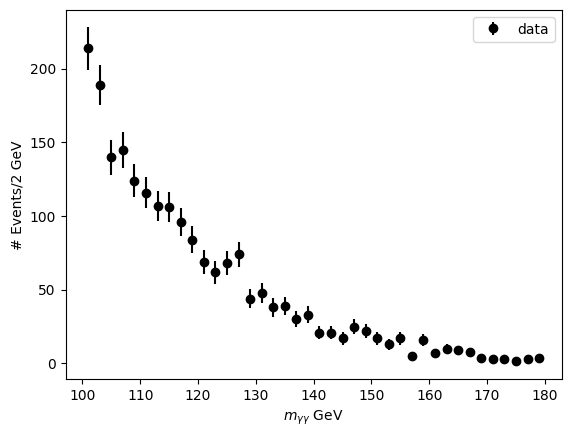

In [5]:
# Truth parameter for this exercies
# A resonance with mass peak 125.5 GeV and width 2GeV
# The decay constant of the expoential background is 20
MH_truth = 125.5
Width_truth=2
Alpha_truth=20

# The signal yield is 20 and the background yield is 2000
Ns_truth = 20
Nb_truth = 2000

# We will study the mass shape between 100GeV and 180GeV in 40 bins
nbins= 40
bins = np.linspace(xmin, xmax, nbins+1)
binCenter = 1/2 *(bins[1:] + bins[:-1])
binWidth = bins[1]-bins[0]
Ns_predict = Ns_truth*binWidth*norm_S(binCenter,MH_truth,Width_truth)
Nb_predict = Nb_truth*binWidth*norm_B(binCenter,Alpha_truth)
Ns_and_Nb  = Ns_predict+Nb_predict

# Set random seed to guarantee reproducibility
np.random.seed(seed=6)

Ndata = np.random.poisson(Ns_and_Nb)

fig =  plt.figure()
plt.cla()
plt.errorbar(binCenter, Ndata, Ndata ** 0.5, fmt="ok",label='data')
#plt.bar(binCenter, Ns_and_Nb, color='orange', label='s+b')
#plt.bar(binCenter, Nb_predict, color='b', label='b only')
plt.xlabel("$m_{\gamma\gamma}$ GeV")
plt.ylabel("# Events/%.1g GeV"%binWidth)
plt.legend()
plt.show()

# Likelihood definition


The likelihood is a joint product of Poisson probability from each bin

$L(\mu|x)=\prod_i^{M}\frac{(\mu S_i + \theta B_i)^{n_i}}{n!} \exp^{-(\mu S_i + \theta B_i)}$,

where $\mu$ is the signal strength and $\theta$ is the background strength.

The binned log likelihood can be approximated as:

$$-2 \mathrm{ln} L(\mu|x) = -2 \sum_i^{M} [ {n_i} \mathrm{ln} (\mu S_i+\theta B_i) -(\mu S_i+ \theta B_i) ]$$




In [1]:
def neg_binned_logL(pars,N_observe,Ns,Nb):
    mu=pars[0]
    bkg=pars[1]
    N_predict  = mu*Ns+bkg*Nb

    # Task 1: Define negative binned log likelihood Write your code here. 
    output= -2 * np.sum(np.log(N_predict)-N_predict)
    
    return -2 * np.log(output)

## Test statistics for discovery test

The test statistics for discovery test is defined as:

$q_0 = -2 ln \frac{L(\mu=0, \widehat{\widehat{\theta}})}{L(\widehat{\mu},\widehat{\theta})}$,
where $\widehat{\mu}$ and $\widehat{\theta}$ are the best fit values of signal strength and background strength, respectively.
$\hat{\hat{\theta}}$ is the best fit of background strength at $\mu=0$ (background-only model).


In [4]:
#
# define q_0 test staistics
# It performs two fit:
# - first fit is background-only model 
# - second fit is signal and background model
#
# This function returns three output
# - q_0
# - first fit output
# - second fit output
#
def q0(N_data,Ns,Nb):
     
    
    # fix mu=0, fit bkg-only 
    # initial parameter of bkg strength is the ratio of data yields to expected bkg yields.
    # bkg strength range is between 0 and factor of two of the ratio of data yields to expected bkg yields.
    #
    bkg_init=np.sum(N_data)/np.sum(Nb)
    bkg_max=2*np.sum(N_data)/np.sum(Nb)
    x0=[0,bkg_init]
    bounds=[[0,0],[0,bkg_max]]
    outfit0 = minimize(fun=neg_binned_logL,x0=x0,args=[N_data, Ns, Nb],bounds=bounds)

    #fit both mu and bkg
    # initial parameter of signal strength is the ratio of data yields subtract from expected bkg yields to expected signal yields. 
    # fit range is between 0 and the ratio of data yields to expected signal yields.
    #
    mu_init=abs(np.sum(N_data-Nb))/np.sum(Ns)
    mu_max=2*np.sum(N_data)/np.sum(Ns)
    
    x0=[mu_init,bkg_init]
    bounds=[[0,mu_max],[0,bkg_max]]
    outfit1 = minimize(fun=neg_binned_logL,x0=x0,args=[N_data, Ns, Nb],bounds=bounds)
    
    # if den is greater than numerator, the test statistics is set to zero in order to avoid NaN
    q0_test=0
    if(outfit1.x[0] > 0):
        num=neg_binned_logL(outfit0.x,N_data, Ns, Nb)
        den=neg_binned_logL(outfit1.x,N_data, Ns, Nb)
        q0_test=num-den
    return [q0_test, outfit0.x, outfit1.x]


## Test statistics for Upper Limit

The test statistics for upper limit is defined as:

$ q_{\mu} = -2 ln \frac{L(\mu, \hat{\hat{\theta}})}{L(\hat{\mu},\hat{\theta})}$,
where $\hat{\mu}$ and $\hat{\theta}$ are the best fit values of signal strength and background strength, respectively.
$\hat{\hat{\theta}}$ is the best fit of background strength at $\mu$ (altternative hypothesis with $\mu$ given).

In [5]:

#
# defin q_mu test staistics
# It performs two fit:
# - first fit fix mu 
# - second fit float mu and theta
#
# This function returns three output
# - q_mu
# - first fit output
# - second fit output
#
def qmu(mu,N_data,Ns,Nb):

    #fix mu, fit bkg strength
    bkg_init=np.sum(N_data)/np.sum(Nb)
    bkg_max=2*np.sum(N_data)/np.sum(Nb)
    
    x0=[mu,bkg_init]
    bounds=[[mu,mu],[0,bkg_max]]
    outfit0 = minimize(fun=neg_binned_logL,x0=x0,args=[N_data, Ns, Nb],bounds=bounds)

    #fit both mu and bkg strength
    mu_init=abs(np.sum(N_data-Nb))/np.sum(Ns)
    mu_max=2*np.sum(N_data)/np.sum(Ns)
    
    x0=[mu_init,bkg_init]
    bounds=[[0,mu_max],[0,bkg_max]]
    outfit1 = minimize(fun=neg_binned_logL,x0=x0,args=[N_data, Ns, Nb],bounds=bounds)
    
    #print(outfit0)
    #print(outfit1)

    # qmu_test is only none-zero when second fit signal strength 
    # is less than tested signal strength
    qmu_test=0
    if(outfit1.x[0] < mu):
        num=neg_binned_logL(outfit0.x,N_data, Ns, Nb)
        den=neg_binned_logL(outfit1.x,N_data, Ns, Nb)
        qmu_test=num-den
    return [qmu_test, outfit0.x, outfit1.x]



## Part1 Calculate expected discovery signifiance (Frequentist approach)

Step 1. Generate signal+background toy experiments with $\mu=1$ to obtain median of the $q_0,toy$ if signal exists.

Step 2. Generate background-only toy experiments with $\mu=0$ to calculate p-value. p-value is fraction of $q_0$ under background-only model with the value greater or equal to the median $q_{0,toy}$. 

In [6]:
#set random seed to guarantee reproducibility
np.random.seed(seed=7)

# Generate 10K toy experiments based on signal and background hypothesis
# Perform discovery test on each toy experiment to obtain q_0 distribtuion
Ntoys=10000
h0_expect=np.zeros(Ntoys)
for i in range(Ntoys):
    toy_hist = np.random.poisson(Ns_and_Nb)
    q0_output,output0,output1=q0(toy_hist,Ns_predict,Nb_predict)
    h0_expect[i]=q0_output

100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:34<00:00, 293.33it/s]


In [7]:
#set random seed to guarantee reproducibility
np.random.seed(seed=8)


# Generate toy experiments based on background only model
Ntoys=10000
h0_test=np.zeros(Ntoys)
for i in range(Ntoys):
    toy_hist = np.random.poisson(Nb_predict)
    q0_out,output0,output1=q0(toy_hist,Ns_predict,Nb_predict)
    h0_test[i]=q0_out


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 283.04it/s]


Expected $q_0(\mu=1)$ : 1.68
Expected pvalue: 0.098
Expected Z-score(1 side)=1.29


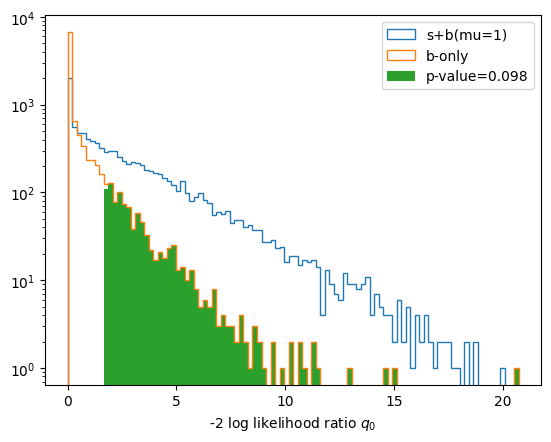

In [8]:
# Calculate expected p-value and expected significance
# Step 1. Find median of the q_0,toy distribution with predicted signal and background
q_med=np.median(h0_expect)

# Step 2. Compute p-value of the q_0,toy using background-only q_0 distribution
pvalue=len(h0_test[h0_test>q_med])/len(h0_test)
Zscore= scipy.stats.norm.ppf(1-pvalue) 

print('Expected $q_0(\mu=1)$ : %.2f'%q_med)
print('Expected pvalue: %.3f'%pvalue)
print('Expected Z-score(1 side)=%.2f'%Zscore)


Xmin=np.min(h0_test)
Xmax=np.max(h0_test)

plt.yscale('log')
plt.hist(h0_expect,bins=100,range=[Xmin,Xmax],histtype='step',label='s+b(mu=1)')
plt.hist(h0_test,bins=100,range=[Xmin,Xmax],histtype='step',label='b-only')
plt.hist(h0_test[h0_test>q_med],bins=100,range=[Xmin,Xmax],label='p-value=%.2g'%pvalue)

plt.xlabel("-2 log likelihood ratio $q_0$")
plt.legend()
plt.show()

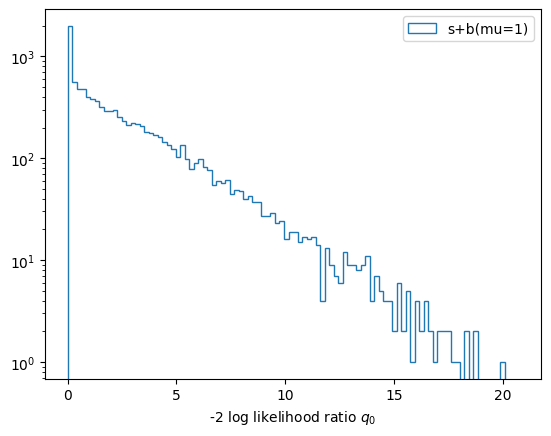

In [9]:
plt.yscale('log')
plt.hist(h0_expect,bins=100,range=[Xmin,Xmax],histtype='step',label='s+b(mu=1)')

plt.xlabel("-2 log likelihood ratio $q_0$")
plt.legend()
plt.show()

## Part 2a Bayesian discovery test

Let's compute the observed significance using Bayesian approach:
$$\mathrm{p-value}= \sqrt{q_0}$$


<IPython.core.display.Math object>

<IPython.core.display.Math object>

q0: 4.207792790033636


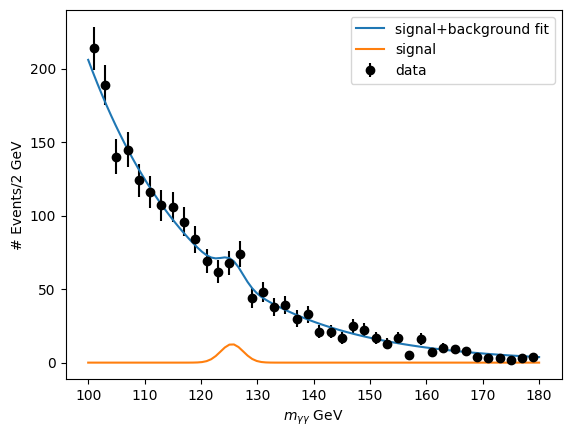

In [10]:
from IPython.display import display, Math

q0_data,outfit0,outfit1=q0(Ndata,Ns_predict,Nb_predict)

xspace = np.linspace(xmin,xmax,100)
NbOnly_fit = outfit0[1]*Nb_truth*binWidth*norm_B(xspace,Alpha_truth)
Ns_fit = outfit1[0]*Ns_truth*binWidth*norm_S(xspace,MH_truth,Width_truth)
Nb_fit = outfit1[1]*Nb_truth*binWidth*norm_B(xspace,Alpha_truth)

display(Math(r'\mathrm{Bkg-only\; fit:} \hat{\mu}=%.2f\;  \hat{\hat{\theta}}=%.2f'%(outfit0[0],outfit0[1])))
display(Math(r'\mathrm{Sig+Bkg\; combined\; fit:} \hat{\mu}=%.2f\;  \hat{\theta}=%.2f'%(outfit1[0],outfit1[1])))
print("q0:",q0_data)

fig =  plt.figure()
plt.cla()
#plt.hist(masses,bins=nbins,range=(xmin,xmax),histtype='step',density=False)
plt.errorbar(binCenter, Ndata, Ndata ** 0.5, fmt="ok",label='data')
#plt.plot(xspace,NbOnly_fit,label='background-only fit')

plt.plot(xspace,Ns_fit+Nb_fit,label='signal+background fit')
plt.plot(xspace,Ns_fit,label='signal')
#plt.axis([100,180,0,0.05])
plt.xlabel("$m_{\gamma\gamma}$ GeV")
plt.ylabel("# Events/%.1g GeV"%binWidth)

#plt.title("$\hat{m}_{H}=%.2f,\hat{f}_{S}=%.3f,\hat{\\alpha}=%.2f$"%(res.x[0],res.x[1],res.x[2]))
plt.legend()
plt.show()

Let's plot the -2 log likelihood as function of $\mu$. In each $\mu$, the background $\theta$ is set to the corresponding best fit value.

100%|██████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 365.58it/s]

Best fit $\mu$=1.57 $	heta=1.01$
p-value Z=\sqrt(q_0): 2.0512905181942505
Signifiance Z=\sqrt(q_0): nan


Text(0, 0.5, '-2 log $L/L_{max}$')

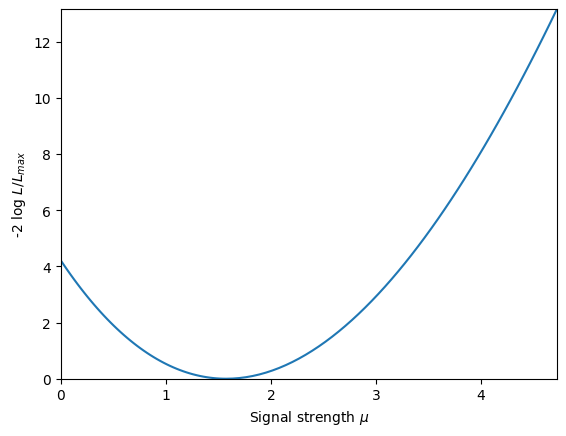

In [11]:
# First, let's get the best fit value of signal and background strength mu, theta
q0_data,outfit0,outfit1=q0(Ndata,Ns_predict,Nb_predict)

# Task2: Calcualte p-value and zscore. Write your code here
pvalue = np.sqrt(q0_data)
zscore = norm.ppf(1-pvalue/2)

# Define 102 points, 
# The first 51 point is between 0 and best fit mu.
# The second 51 points are between besft fit mu and factor of 3 of the best fit mu.
Npoints =100
xspace1 = np.linspace(0,outfit1[0],51)
xspace2 = np.linspace(outfit1[0],outfit1[0]*3,51)
xspace = [*xspace1, *xspace2]


# scan mu to compute each q_mu
qmulist = np.zeros(len(xspace))

for i in range(len(xspace)):
    qmu_data,outfit0,outfit1=qmu(xspace[i],Ndata,Ns_predict,Nb_predict)
    den = neg_binned_logL(outfit0,Ndata, Ns_predict,Nb_predict)
    num = neg_binned_logL(outfit1,Ndata, Ns_predict,Nb_predict)
    qmulist[i]=den-num

print("Best fit $\mu$=%.2f $\theta=%.2f$"%(outfit1[0],outfit1[1]))
print("p-value Z=\sqrt(q_0):", pvalue)
print("Signifiance Z=\sqrt(q_0):", zscore)
plt.plot(xspace,qmulist,label='likelihood')
plt.xlim(xspace[0],xspace[-1])
plt.ylim(0,np.max(qmulist))

plt.xlabel('Signal strength $\mu$')
plt.ylabel('-2 log $L/L_{max}$')

## Part2b Bayesian Upper limit Credibility Level

The significance is less than 5$\sigma$ which fails the discovery test.
We can calculate upper limit using Bayesian approach. It is 95% probablity for $\mu$ to be less or equal to $\mu_{obs}$.

$$CL = \frac{\int_{0}^{\mu_{95\%}} L(\mu|x) d\mu} {\int_{0}^{\infty} L(\mu|x) d\mu}$$

95% CL Upper Limit:  2.8340559420089937


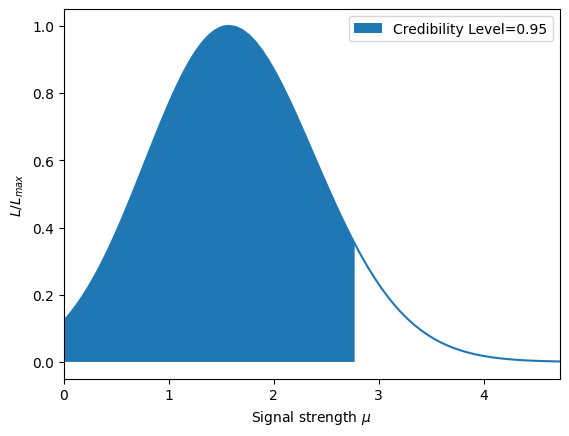

In [12]:
# Convert the binned logliklihood to the Likelihood and calculate 95% upper limit
#
CL=0.95
LHList=np.exp(-0.5*qmulist) 
sumLH=np.sum(LHList)
sumL=0
idx95=0
for i in range(len(LHList)):
    sumL += LHList[i]/sumLH
    idx95=i
    if(sumL >= 0.950):
        break

print("95% CL Upper Limit: ",xspace[idx95])
fig, ax = plt.subplots()
ax.plot(xspace,LHList)
ax.fill_between(xspace[0:idx95],0,LHList[0:idx95],label='Credibility Level=%.2f'%CL)
plt.xlim(xspace[0],xspace[-1])
plt.xlabel('Signal strength $\mu$')
plt.ylabel('$L/L_{max}$')
plt.legend()

## Part3a: Frequentist Discovery test

We will generate background-only toy expeirments and count fraction of the $q_0$ less or equal to the observed $q_{0,obs}.$ 

q0: 4.207792790033636
$\sqrt{q0}$: 2.0512905181942505
pvalue: 0.0206
Z-score(1 side)=2.04
The frequentist p-value is similar to Bayesian p-value.


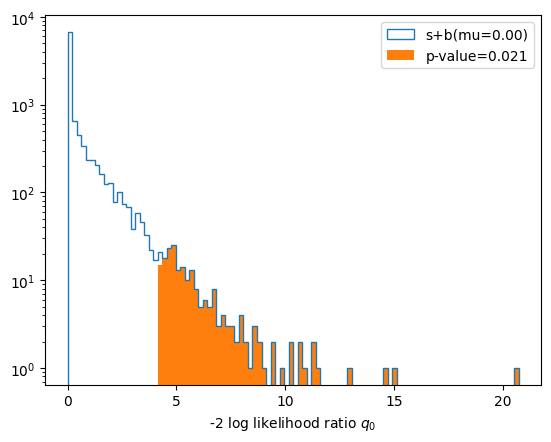

In [13]:
# Calculate p-value using Test statistics for discovery test

mu=0
q0_data,output0,output1=q0(Ndata,Ns_predict,Nb_predict)

Xmin=np.min(h0_test)
Xmax=np.max(h0_test)

pvalue=len(h0_test[h0_test>q0_data])/len(h0_test)

print('q0:', q0_data)
print('$\sqrt{q0}$:', (q0_data)**.5)
print('pvalue:',pvalue)
print('Z-score(1 side)=%.2f'%scipy.stats.norm.ppf(1-pvalue))
print('The frequentist p-value is similar to Bayesian p-value.')

plt.yscale('log')
plt.hist(h0_test,bins=100,range=[Xmin,Xmax],histtype='step',label='s+b(mu=%.2f)'%mu)
plt.hist(h0_test[h0_test>q0_data],bins=100,range=[Xmin,Xmax],label='p-value=%.2g'%pvalue)

plt.xlabel("-2 log likelihood ratio $q_0$")
plt.legend()
plt.show()

## Part 3b Calculate Frequentist upperlimit.

The 95% Confidence Level upper limit $\mu_{95}$ is calculated through the procedure:
1. Generate signal+background toy experiments with $\mu_{95}$.
2. Calculate p-value by counting fraction of the $q_{\mu}$ less or equal to $q_{\mu_{95}}$.
3. The 95% CL means p-value is 0.05.


In [15]:
# Define a function to compute p-value of qmu 

Ntoys=10000
def qmu_pvalue(mu,Ndata,Ns_predict,Nb_predict):
    N_predict  = mu*Ns_predict+Nb_predict

    hmu_expect=np.zeros(Ntoys)
    for i in range(Ntoys):
        # Generate toy experiment based on signal (mu)+background model
        toy_hist = np.random.poisson(N_predict)
        # Compute qmu of each toy experiment
        qmu_output,output0,output1=qmu(mu,toy_hist,Ns_predict,Nb_predict)
        hmu_expect[i]=qmu_output

    # compute qmu of pseduo-data    
    qmu_data,output0,output1=qmu(mu,Ndata,Ns_predict,Nb_predict)

    # calculate fraction of toy experiments with qmu greater or equal to the qmu of pseudo-data
    pvalue=len(hmu_expect[hmu_expect>qmu_data])/len(hmu_expect) #write your code here
    return [pvalue,hmu_expect]

In [16]:
# Define a function which performs binary search to look for 95% Confidence Level limit
def CalUpperLimit(alpha,N_data,Ns_predict,Nb_predict):

    #Search mu_95 between best fit of strength mu and mu+2 Z, Z=sqrt{q_0,obs}
    q0_output,output0,output1=q0(N_data,Ns_predict,Nb_predict)
    
    high=output1[0]
    low=high+2* q0_output**.5
    print("high p-value \mu=%.2f low p-value \mu=%.3f"%(high,low))

    pval_UL=1
    mu_UL=(high+low)/2
    qmu_UL=np.zeros(Ntoys)

    # Perform binary search within 0.002 range of target p-value 
    while True:
        mu_UL=(high+low)/2
        pval_UL, qmu_UL=qmu_pvalue(mu_UL,N_data,Ns_predict,Nb_predict)
        print("\mu=%.3f p-value=%.3f"%(mu_UL,pval_UL))
        if (abs(high - low)<0.002) or (abs(pval_UL-alpha)<0.002):
            break

        if pval_UL>alpha :
            high=mu_UL
        else:
            low=mu_UL

    return (mu_UL, qmu_UL, pval_UL)

In [17]:
# Execute function to search for 95% CL limit of signal strength

mu_UL, qmu_UL, pval_UL=CalUpperLimit(0.05,Ndata,Ns_predict,Nb_predict)



high p-value \mu=1.57 low p-value \mu=5.677


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 356.83it/s]


\mu=3.626 p-value=0.009


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.48it/s]


\mu=2.600 p-value=0.108


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.72it/s]


\mu=3.113 p-value=0.032


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 365.65it/s]


\mu=2.857 p-value=0.064


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.65it/s]


\mu=2.985 p-value=0.045


100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.24it/s]

\mu=2.921 p-value=0.052


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

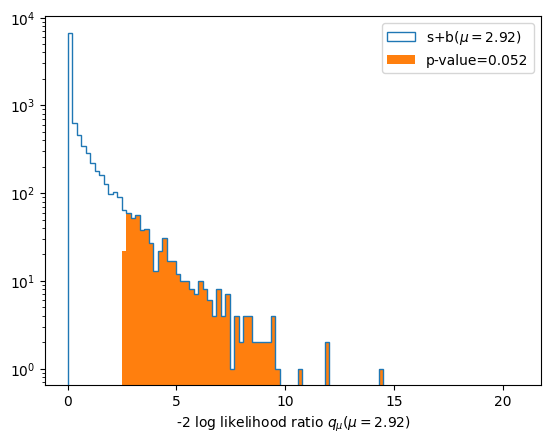

In [18]:
# Print results

qmu_data,output0,output1=qmu(mu_UL,Ndata,Ns_predict,Nb_predict)
pvalue=len(qmu_UL[qmu_UL>qmu_data])/len(qmu_UL)

display(Math(r'\mathrm{\mu+Bkg\; fit:} \mu_{95}=%.2f\;  \hat{\hat{\theta}}=%.2f'%(output0[0],output0[1])))
display(Math(r'\mathrm{Sig+Bkg\; combined\; fit:} \hat{\mu}=%.2f\;  \hat{\theta}=%.2f'%(output1[0],output1[1])))

display(Math(r'q_{\mu_{95}}=%.2f\; \mathrm{pvalue=}%.2f'%(qmu_data,pvalue)))

#print('median',np.median(hmu_bkgonly))
plt.yscale('log')
#plt.hist(hmu_bkgonly,bins=100,range=[Xmin,Xmax],histtype='step',label='b-only')
plt.hist(qmu_UL,bins=100,range=[Xmin,Xmax],histtype='step',label='s+b($\mu=%.2f$)'%mu_UL)
plt.hist(qmu_UL[qmu_UL>qmu_data],bins=100,range=[Xmin,Xmax],label='p-value=%.2g'%pvalue)

plt.xlabel("-2 log likelihood ratio $q_{\mu}(\mu=%.2f)$"%mu_UL)
plt.legend()
plt.show()

Task 3: Write your answers in this cell

a) Compare results of expected discovery significance to observed significance in Frequentist approach and Bayesian approach

[Ans: The Frequentist expected discovery significance followed a certain threshold of background only whereas the observed significance followed the distribution of s+b
The Bayesian expected significance is based on likelihood & predicting the signal strength via given parameters. The observed significance is adjusted according to the expected significance & goes along the s+b fit using the likelihood function]

b) Compare 95% CL Upper Limit of signal strength in Frequentist approach and Bayesian approach

[Ans: The Frequentist approach takes multiple steps where one must calculate the p-value & adjusting until the p-value reaches 0.05
The Bayesian approach gives you a range from integrating 0 to 95 percent where the true mu value is less than the upper limit 95% mu]

c) Describe the procedure to evaluate expected 95% CL Upper Limit of signal strength using Frequentist method

[Ans:
1) Generate a test statistic to differentiate between signal & background
2) Find the signal strength of mu so that the likelihood ratio true mu >= mu & contains 95% of the true mu's likelihood integral
3) Average all mu values across your likelihood data to get the upper limit]
